In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Model libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Evaluation libraries for imbalanced classification
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# SHAP for model interpretation
import shap

In [4]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)

In [5]:
# Load the engineered data
print("Loading engineered employee data...")
data_path = '../data/processed/employees_engineered.csv'
employees_df = pd.read_csv(data_path)

print(f"Dataset shape: {employees_df.shape}")
print(f"Attrition rate: {employees_df['Attrition'].mean():.2%}")

Loading engineered employee data...
Dataset shape: (3892, 42)
Attrition rate: 22.92%


In [6]:
# Check for missing values
missing_values = employees_df.isnull().sum()
print("\nMissing values in dataset:")
print(missing_values[missing_values > 0])  # Only show columns with missing values


Missing values in dataset:
ExitDate               3000
SalaryRatioToTenure       1
dtype: int64


### Features Preprocessing

In [7]:
# Feature definitions
numeric_features = [
    'Age', 'DistanceFromHome', 'YearsAtCompany', 'YearsSinceLastPromotion',
    'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance',
    'PerformanceRating', 'MonthlyIncome', 'TrainingTimesLastYear',
    'YearsSinceHire', 'TimeToPromotion', 'SalaryRatioToLevel', 'SalaryRatioDept',
    'SalaryRatioToTenure', 'OverallSatisfaction', 'EngagementScore', 
    'CareerVelocity', 'IncomeToAgeRatio', 'EducationLevel'
]

categorical_features = [
    'Department', 'JobLevel', 'Gender', 'CommuteDifficulty', 
    'TrainingEngagement', 'AgeGroup'
]

binary_features = [
    'Overtime', 'WorkLifeImbalance', 'StagnationRisk', 'HighPerformer', 'LowPerformer'
]

# Verify all features exist
all_features = numeric_features + categorical_features + binary_features
missing_cols = [col for col in all_features if col not in employees_df.columns]
if missing_cols:
    print(f"Warning: Removing missing columns: {missing_cols}")
    numeric_features = [c for c in numeric_features if c not in missing_cols]
    categorical_features = [c for c in categorical_features if c not in missing_cols]
    binary_features = [c for c in binary_features if c not in missing_cols]

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('selector', 'passthrough')  # No transformation needed for binary features
])

# Full preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('numeric', numeric_pipeline, numeric_features),
#         ('categorical', categorical_pipeline, categorical_features),
#         ('binary', binary_pipeline, binary_features)
#     ],
#     remainder='drop'  # Only keep specified features
# )

preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (categorical_pipeline, categorical_features),
    (binary_pipeline, binary_features),
    remainder='drop',
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Prepare data
X = employees_df.copy()
y = employees_df['Attrition'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Processed training data shape: (2919, 48)
Processed test data shape: (973, 48)


In [8]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 121 to 2851
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          2919 non-null   float64
 1   DistanceFromHome             2919 non-null   float64
 2   YearsAtCompany               2919 non-null   float64
 3   YearsSinceLastPromotion      2919 non-null   float64
 4   JobSatisfaction              2919 non-null   float64
 5   EnvironmentSatisfaction      2919 non-null   float64
 6   WorkLifeBalance              2919 non-null   float64
 7   PerformanceRating            2919 non-null   float64
 8   MonthlyIncome                2919 non-null   float64
 9   TrainingTimesLastYear        2919 non-null   float64
 10  YearsSinceHire               2919 non-null   float64
 11  TimeToPromotion              2919 non-null   float64
 12  SalaryRatioToLevel           2919 non-null   float64
 13  SalaryRatioDept      

In [9]:
X_train_processed.head()

,Age,DistanceFromHome,YearsAtCompany,YearsSinceLastPromotion,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,PerformanceRating,MonthlyIncome,TrainingTimesLastYear,...,TrainingEngagement_Low,TrainingEngagement_Medium,AgeGroup_30s,AgeGroup_40s,AgeGroup_50+,Overtime,WorkLifeImbalance,StagnationRisk,HighPerformer,LowPerformer
121,-1.173465,-0.055662,-0.579943,0.144527,-1.456077,-1.31207,-0.261567,-1.228226,-1.111357,1.579344,...,0.0,0.0,0.0,0.0,0.0,False,0,0,0,1
2302,1.466322,0.626230,0.514372,1.272537,0.116870,1.49032,1.433249,-0.115504,-0.623225,-0.950669,...,1.0,0.0,0.0,1.0,0.0,False,0,0,0,0
2534,-1.063474,-0.875465,0.783609,1.272537,1.042134,0.55619,0.585841,0.997219,0.482328,-1.131384,...,1.0,0.0,0.0,0.0,0.0,False,0,0,1,0
336,-0.183545,-0.917604,1.052845,1.272537,-1.733656,0.55619,0.585841,-0.115504,-1.145533,2.121490,...,0.0,0.0,1.0,0.0,0.0,False,0,1,0,0
2870,0.256420,-0.681368,-1.283432,-0.983482,-0.345761,-1.31207,-1.108975,-1.228226,0.289848,0.073384,...,0.0,1.0,1.0,0.0,0.0,True,1,0,0,1


In [10]:
# Check for any remaining missing values
missing_train = X_train_processed.isnull().sum().sum()
missing_test = X_test_processed.isnull().sum().sum()

if missing_train > 0:
    print(f"Warning: {missing_train} missing values remain in the processed training data")
if missing_test > 0:
    print(f"Warning: {missing_test} missing values remain in the processed test data")


In [11]:
# Get feature names for later use with SHAP
feature_names = X_train_processed.columns.tolist()

### Model Training

In [12]:
# Define and train models
print("\nTraining models on imbalanced data...")

# Dictionary to store models and results
models = {}
results = {}
feature_importances = {}
shap_values_dict = {}

# 1. Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',  # Works well with small datasets
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_processed, y_train)
models['Logistic Regression'] = lr_model

# 2. XGBoost
print("\nTraining XGBoost...")
# Calculate scale_pos_weight for imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance without changing class distribution
    random_state=42
)
xgb_model.fit(X_train_processed, y_train)
models['XGBoost'] = xgb_model

# 3. LightGBM
print("\nTraining LightGBM...")
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    is_unbalance=True,  # Handle imbalance internally
    random_state=42
)
lgbm_model.fit(X_train_processed, y_train)
models['LightGBM'] = lgbm_model


Training models on imbalanced data...

Training Logistic Regression...

Training XGBoost...

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 669, number of negative: 2250
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 2919, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.229188 -> initscore=-1.212901
[LightGBM] [Info] Start training from score -1.212901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu


Evaluating Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7770
ROC AUC Score: 0.5860
F1 Score: 0.0606
Average Precision: 0.3011
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       750
           1       0.88      0.03      0.06       223

    accuracy                           0.78       973
   macro avg       0.83      0.52      0.47       973
weighted avg       0.80      0.78      0.69       973



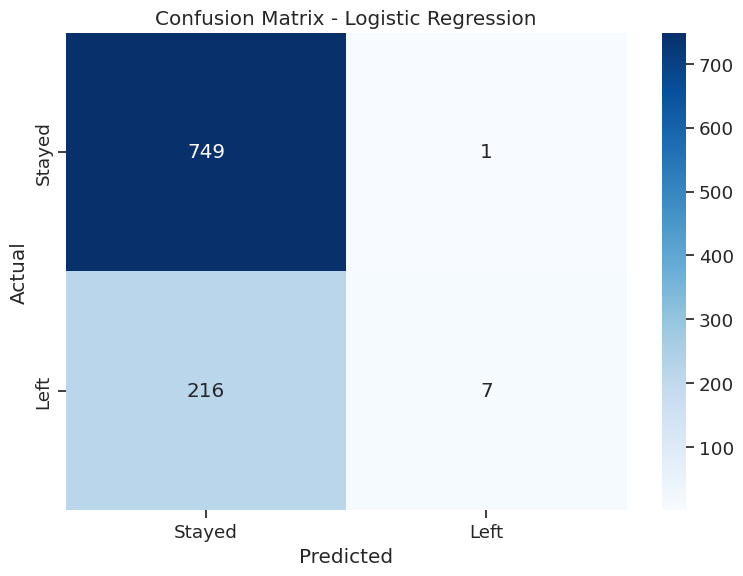

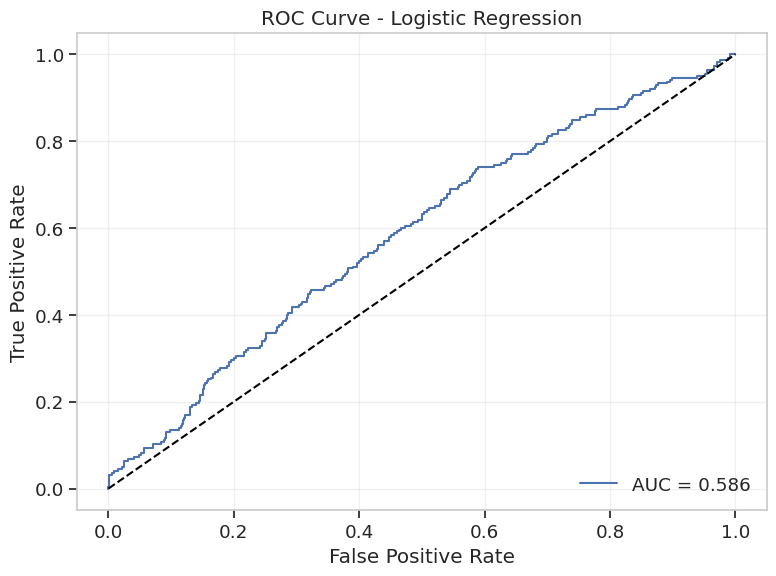

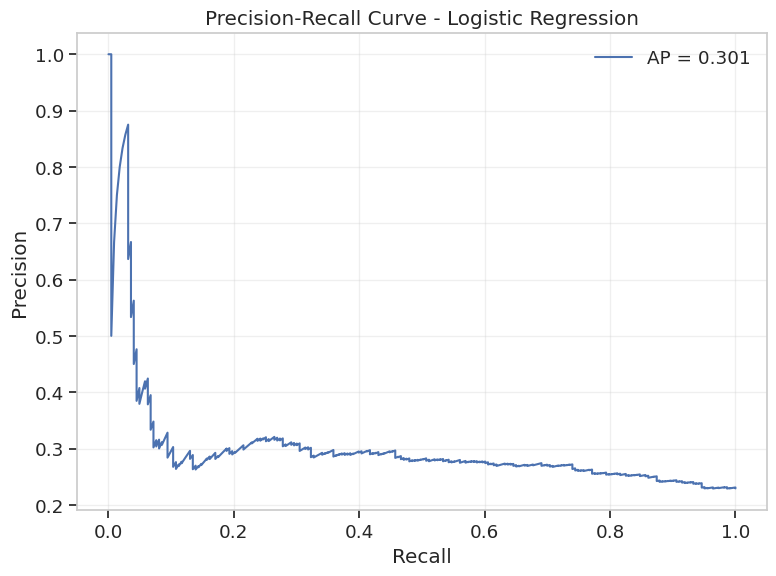


Calculating SHAP values for Logistic Regression...


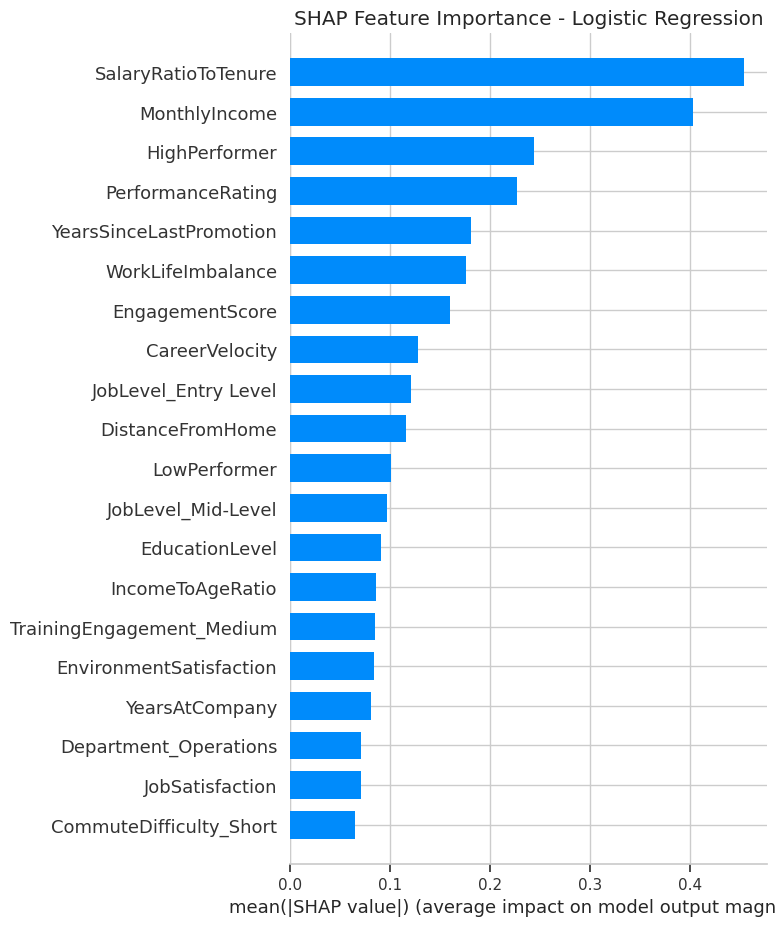

Error calculating SHAP values for Logistic Regression: loop of ufunc does not support argument 0 of type float which has no callable rint method

Evaluating XGBoost...

XGBoost Results:
Accuracy: 0.6300
ROC AUC Score: 0.5373
F1 Score: 0.2771
Average Precision: 0.2490
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       750
           1       0.25      0.31      0.28       223

    accuracy                           0.63       973
   macro avg       0.52      0.52      0.51       973
weighted avg       0.66      0.63      0.64       973



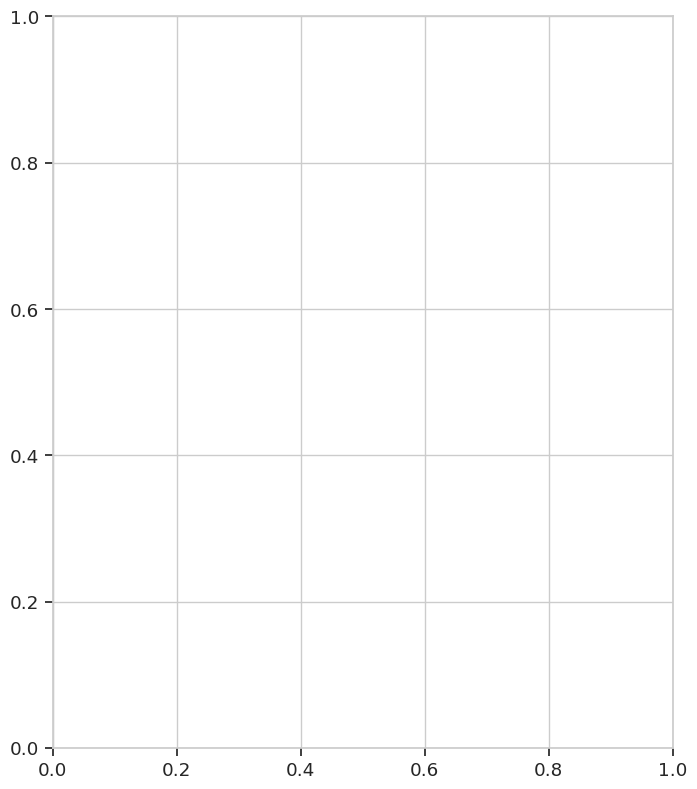

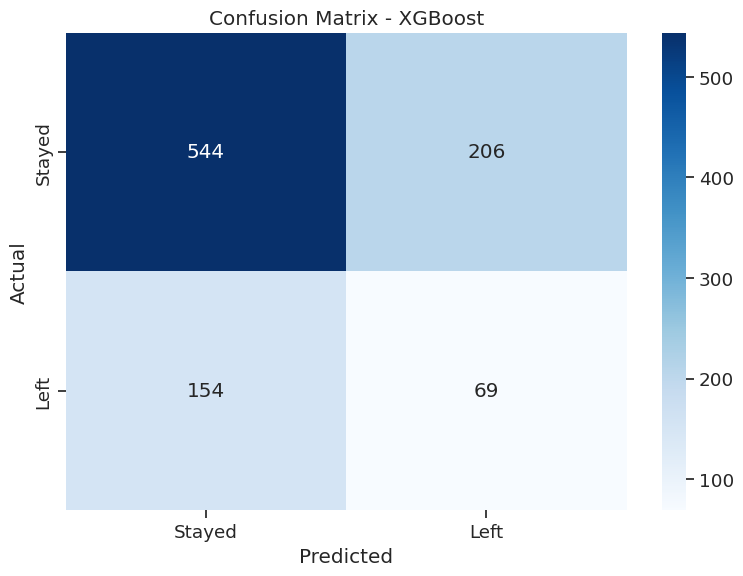

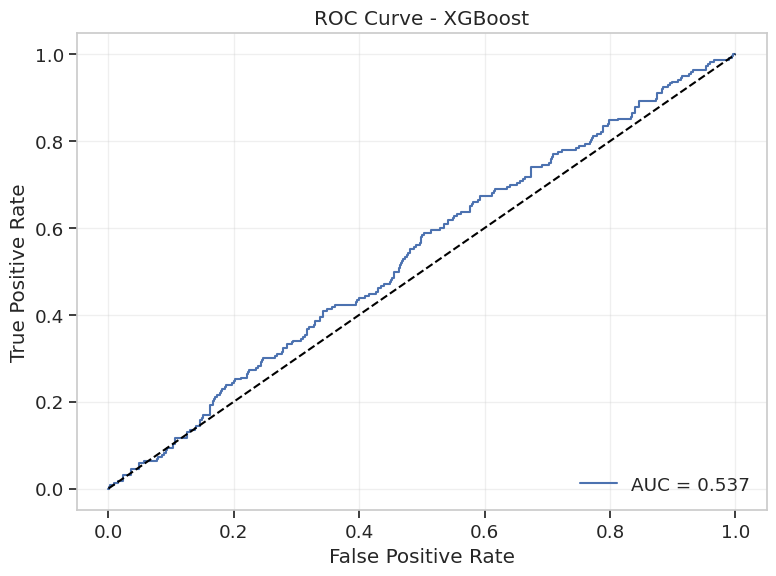

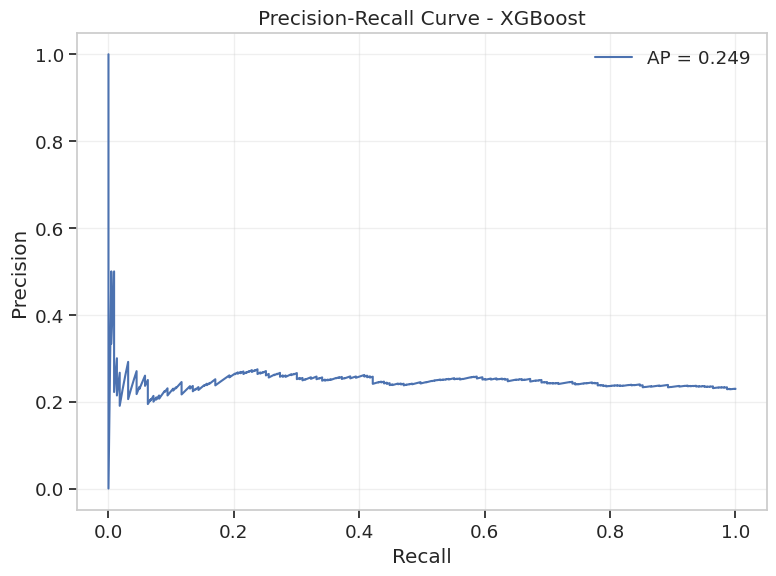

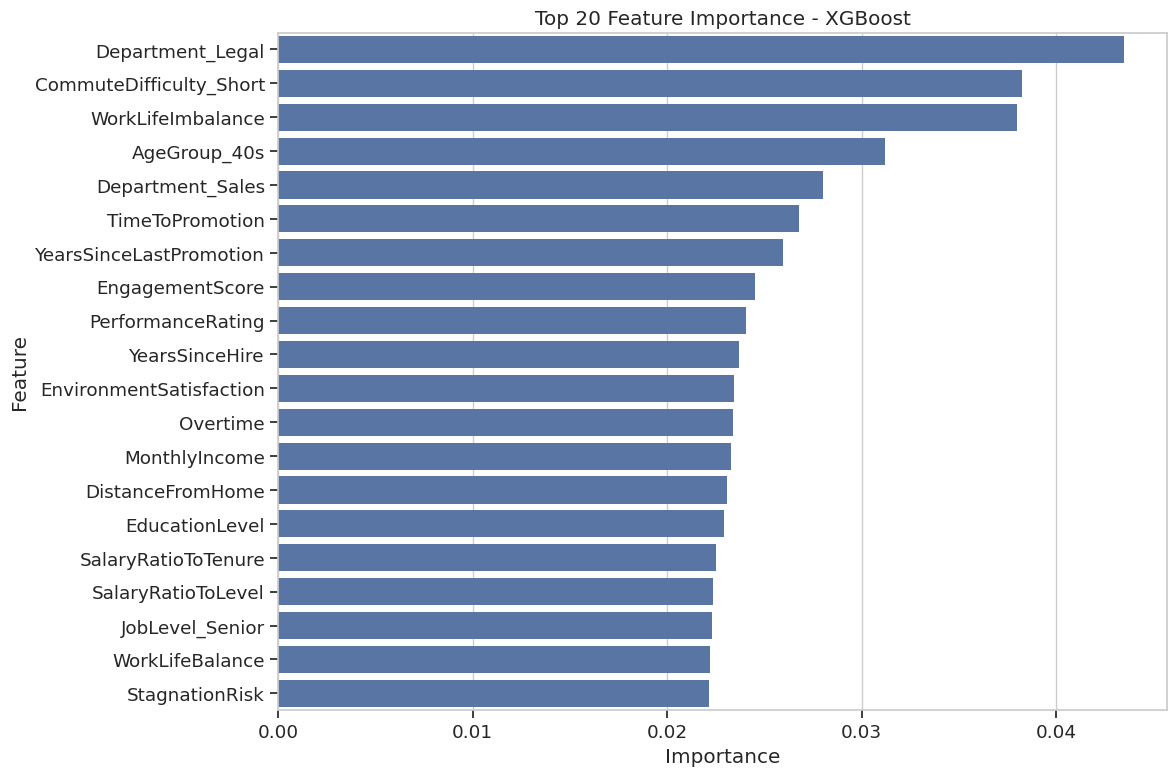


Calculating SHAP values for XGBoost...


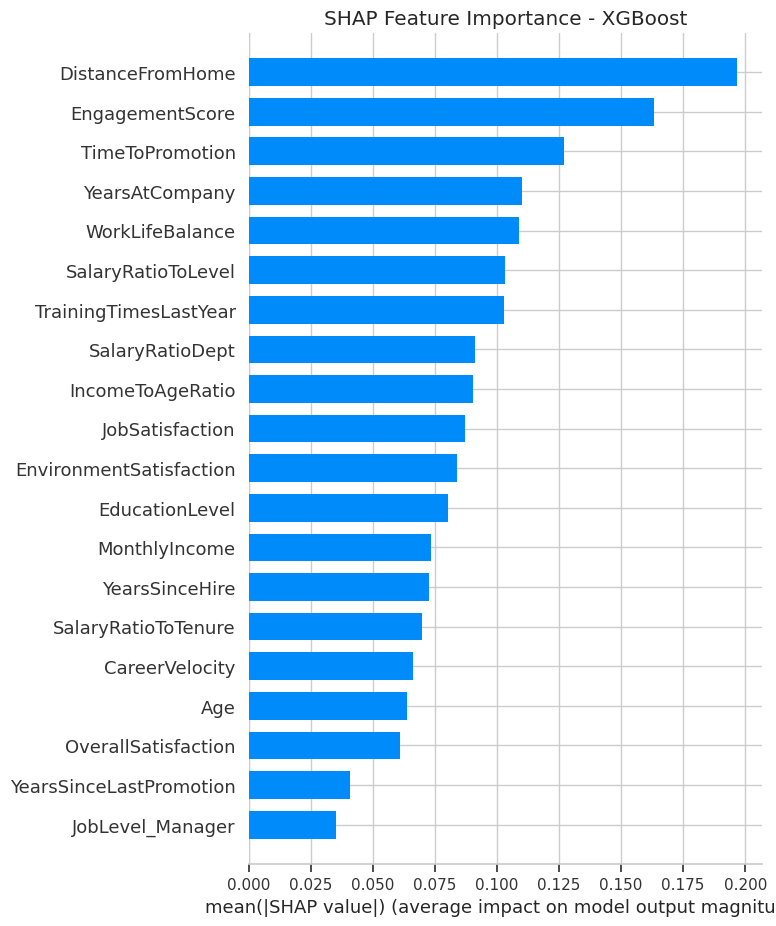

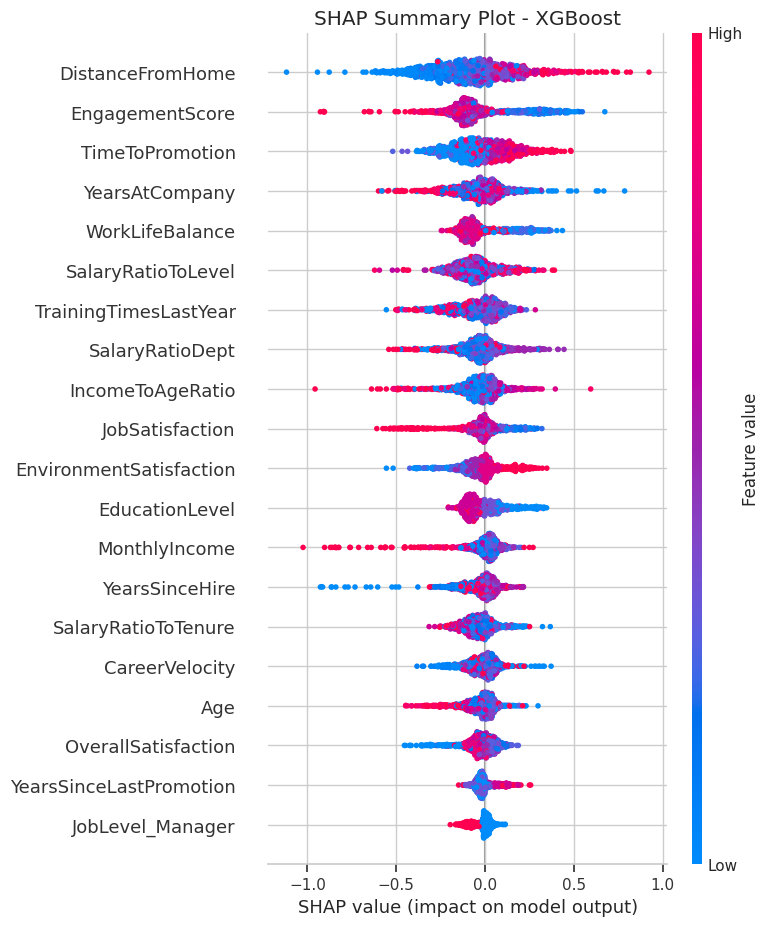

<Figure size 1000x700 with 0 Axes>

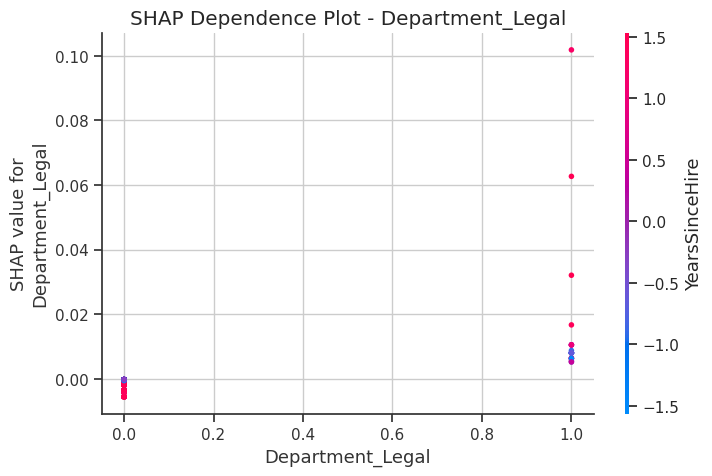

<Figure size 1000x700 with 0 Axes>

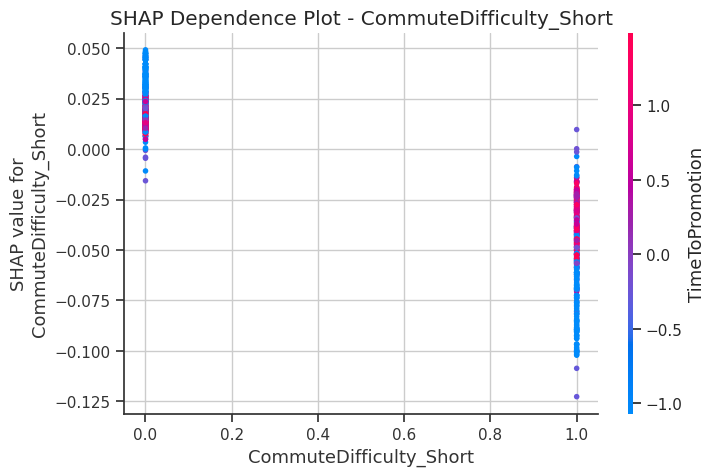

<Figure size 1000x700 with 0 Axes>

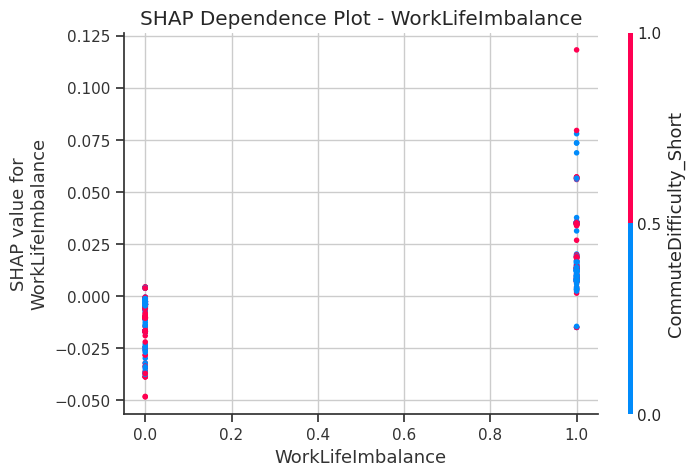


Evaluating LightGBM...

LightGBM Results:
Accuracy: 0.6125
ROC AUC Score: 0.5304
F1 Score: 0.2900
Average Precision: 0.2567
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       750
           1       0.25      0.35      0.29       223

    accuracy                           0.61       973
   macro avg       0.52      0.52      0.51       973
weighted avg       0.66      0.61      0.63       973



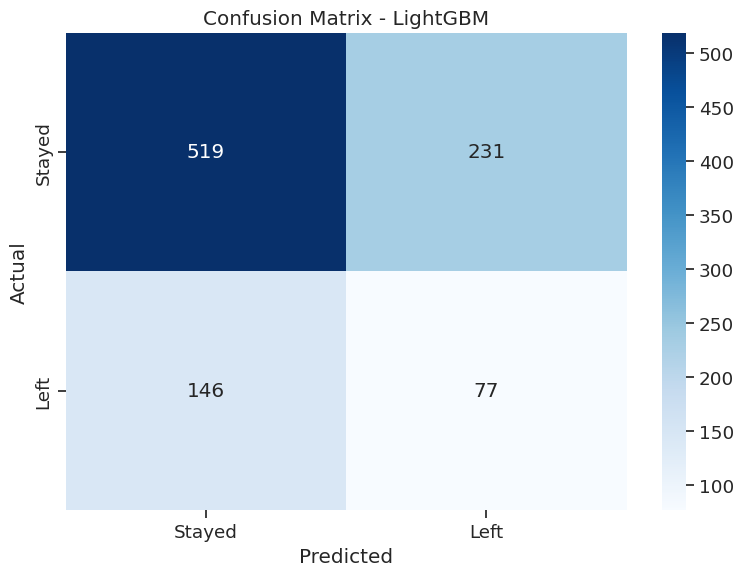

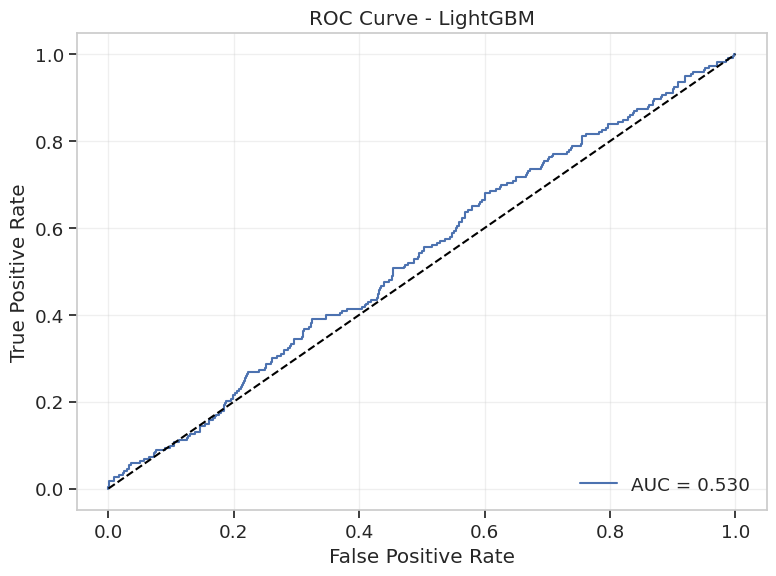

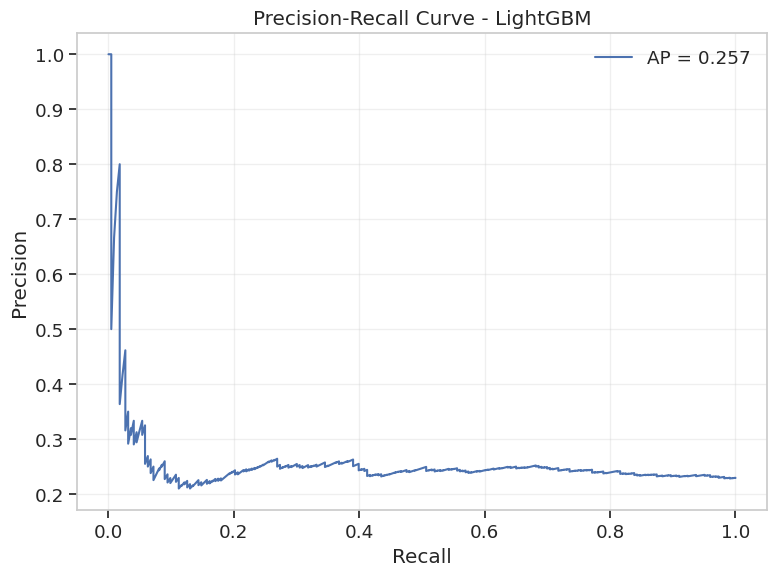

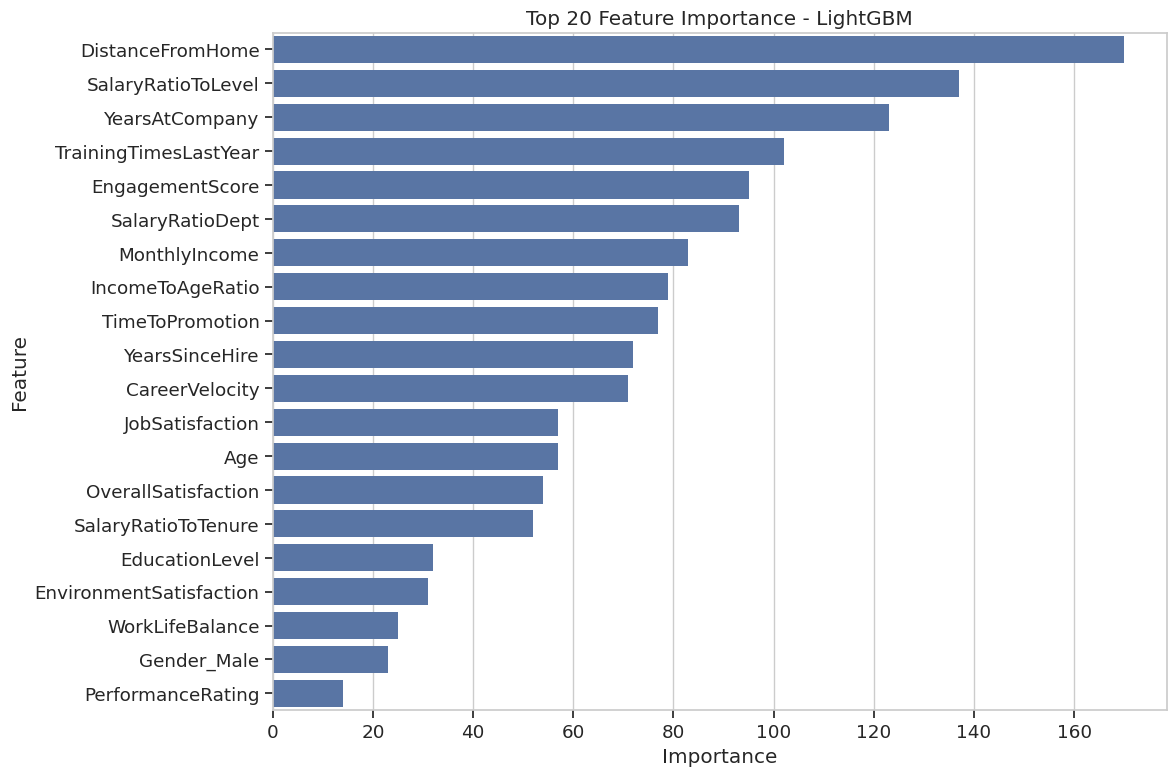


Calculating SHAP values for LightGBM...


/home/codespace/.local/share/virtualenvs/hr-attrition-analytics-4iIZdCNj/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


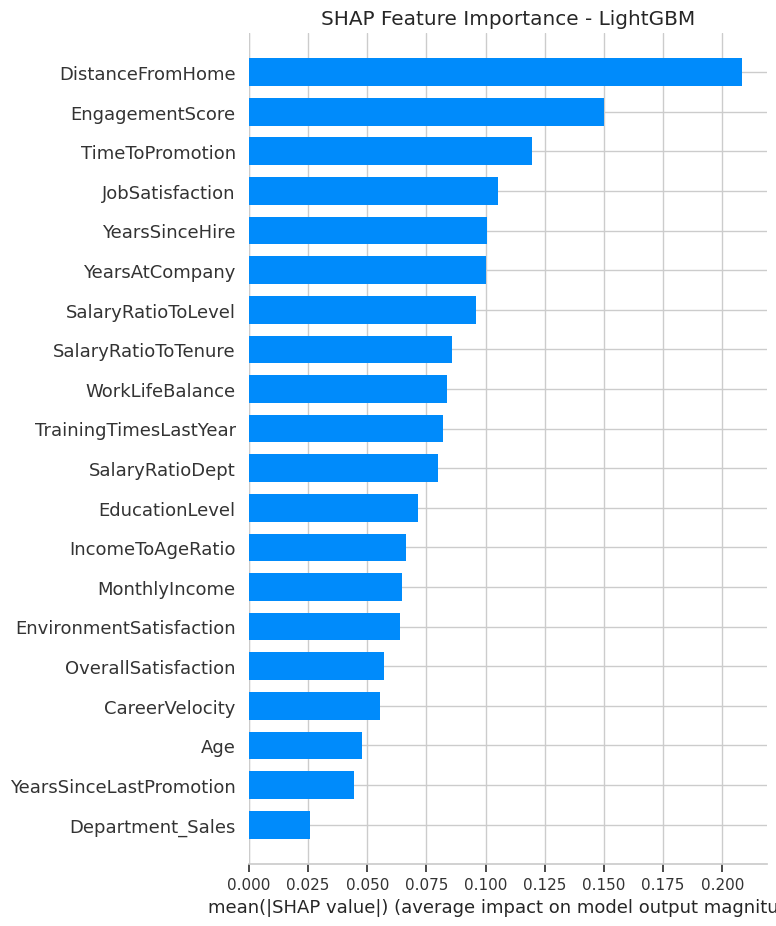

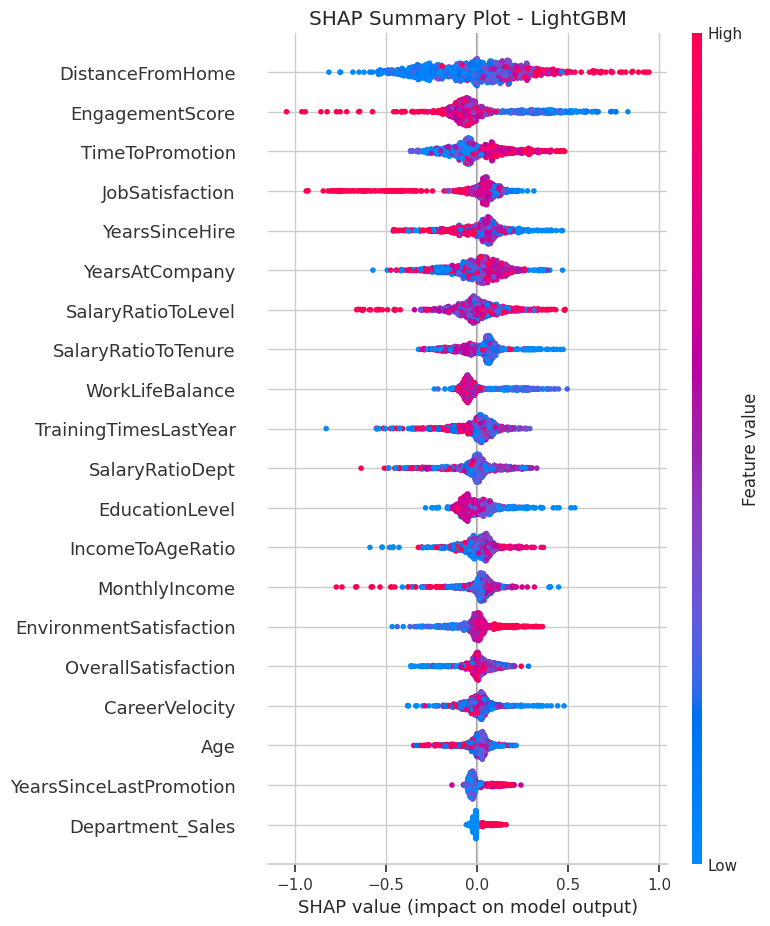

<Figure size 1000x700 with 0 Axes>

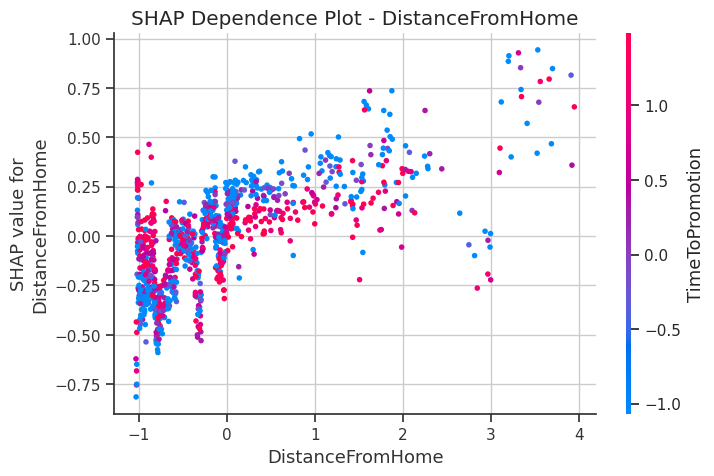

<Figure size 1000x700 with 0 Axes>

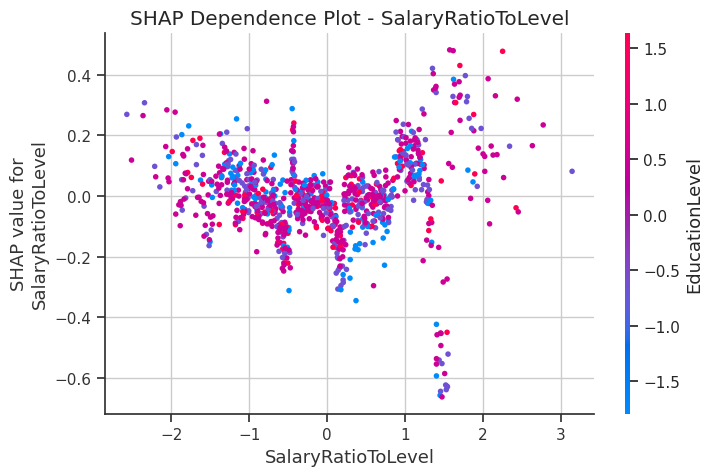

<Figure size 1000x700 with 0 Axes>

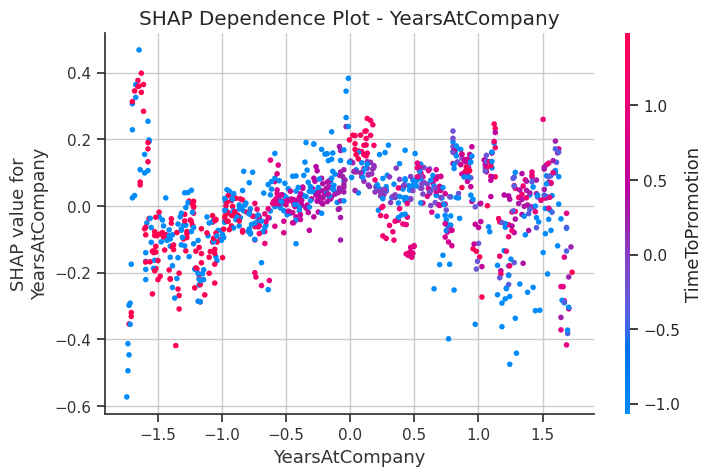

In [13]:
# Evaluate all models
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:,1]
    
    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate precision-recall and average precision (better for imbalanced data)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'avg_precision': avg_precision,
        'classification_report': report,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba,
        'precision': precision,
        'recall': recall
    }
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Classification Report:\n{report}")
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Stayed', 'Left'], 
                yticklabels=['Stayed', 'Left'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    
    # ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Precision-Recall curve (better for imbalanced classification)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Extract feature importance for tree-based models
    if name in ['XGBoost', 'LightGBM']:
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame with feature names and importances
        feature_importances[name] = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        n_features = min(20, len(feature_importances[name]))
        sns.barplot(
            x='Importance',
            y='Feature',
            data=feature_importances[name].head(n_features)
        )
        plt.title(f'Top {n_features} Feature Importance - {name}')
        plt.tight_layout()
        plt.show()
    
    # Calculate SHAP values for model interpretation
    print(f"\nCalculating SHAP values for {name}...")
    try:
        if name == 'Logistic Regression':
            # For logistic regression, create an explainer for the coefficients
            explainer = shap.LinearExplainer(model, X_train_processed)
            # Get SHAP values for the test set
            shap_values = explainer.shap_values(X_test_processed)
            
        elif name == 'XGBoost':
            # For XGBoost, use Tree explainer
            explainer = shap.TreeExplainer(model)
            # Get SHAP values for the test set
            shap_values = explainer.shap_values(X_test_processed)
            
        elif name == 'LightGBM':
            # For LightGBM, use Tree explainer
            explainer = shap.TreeExplainer(model)
            # Get SHAP values for the test set
            shap_values = explainer.shap_values(X_test_processed)
            # LightGBM returns a list of shap values for each class, get the one for class 1
            if isinstance(shap_values, list) and len(shap_values) > 1:
                shap_values = shap_values[1]
        
        # Store SHAP values for later use
        shap_values_dict[name] = {
            'values': shap_values,
            'explainer': explainer
        }
        
        # Summary plot shows the top features by SHAP value magnitude
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values, 
            X_test_processed, 
            max_display=20,
            plot_type="bar", 
            show=False
        )
        plt.title(f'SHAP Feature Importance - {name}')
        plt.tight_layout()
        plt.show()
        
        # SHAP summary dot plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values, 
            X_test_processed, 
            max_display=20,
            show=False
        )
        plt.title(f'SHAP Summary Plot - {name}')
        plt.tight_layout()
        plt.show()
        
        # Display detailed SHAP dependence plots for top features
        if name in ['XGBoost', 'LightGBM'] and feature_importances[name] is not None:
            top_features = feature_importances[name]['Feature'].head(3).tolist()
            for feature in top_features:
                if feature in X_test_processed.columns:
                    plt.figure(figsize=(10, 7))
                    shap.dependence_plot(
                        feature, 
                        shap_values, 
                        X_test_processed,
                        show=False
                    )
                    plt.title(f'SHAP Dependence Plot - {feature}')
                    plt.tight_layout()
                    plt.show()
    
    except Exception as e:
        print(f"Error calculating SHAP values for {name}: {e}")
        continue


Model Performance Comparison:
                 Model  Accuracy       AUC  F1 Score  Avg Precision
0  Logistic Regression  0.776978  0.586009  0.060606       0.301148
2             LightGBM  0.612539  0.530416  0.290019       0.256693
1              XGBoost  0.630010  0.537274  0.277108       0.248969


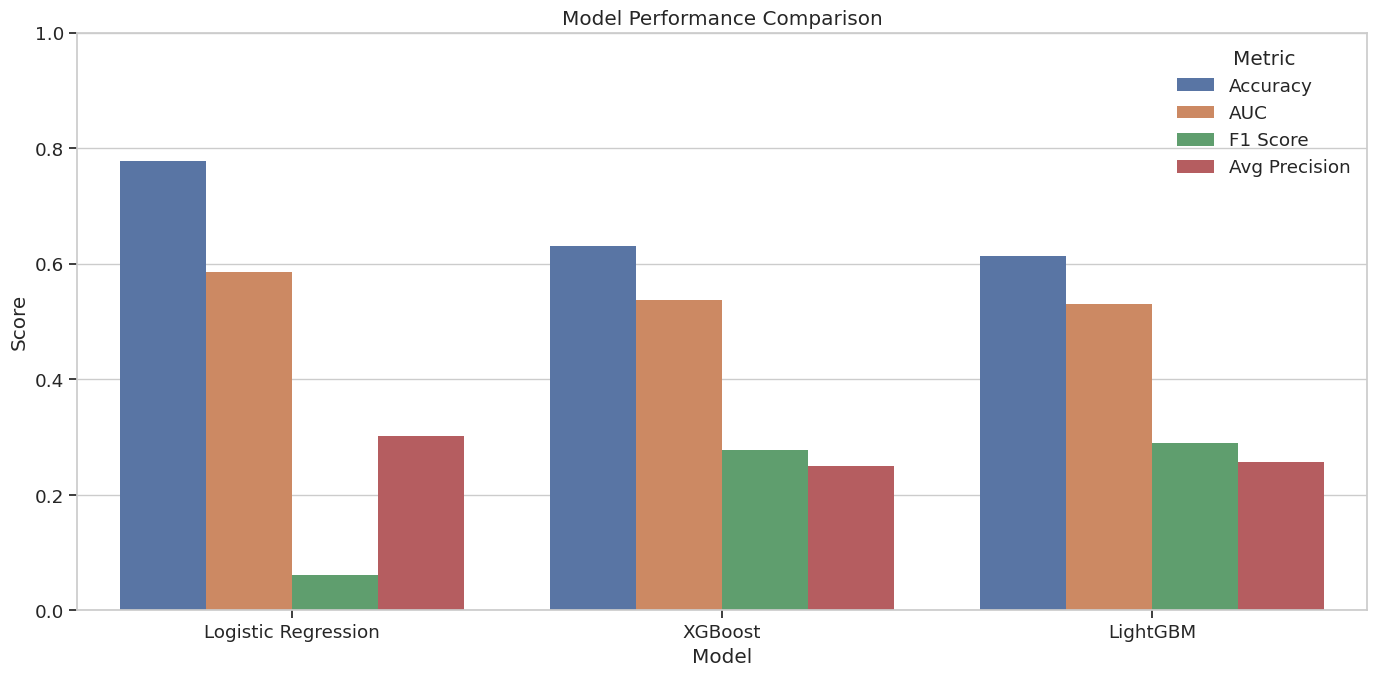

In [14]:
# Compare model performance
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'AUC': [results[m]['auc'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results],
    'Avg Precision': [results[m]['avg_precision'] for m in results]
})

print("\nModel Performance Comparison:")
print(model_comparison.sort_values('Avg Precision', ascending=False))

plt.figure(figsize=(14, 7))
model_comparison_melted = pd.melt(model_comparison, id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=model_comparison_melted)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Why Recall Is Critical in Attrition Prediction

Recall answers the question: "Of all employees who actually left, how many did we correctly identify?"

In attrition prediction, a false negative (missing an employee who will leave) is typically more costly than a false positive (flagging someone who won't leave) because:

1. The cost of losing a valuable employee is substantial - recruitment costs, productivity loss, knowledge drain, and training investments
2. Implementing retention strategies for employees who aren't flight risks still builds engagement and loyalty
3. Missing attrition risk means losing the opportunity to intervene before it's too late

### Why F1 Score Also Matters

F1 score balances precision and recall, which is important because:
- While recall focuses on finding all potential leavers, precision ensures we're not wasting resources on too many false alarms
- It provides a single metric to compare models when you need to balance identifying at-risk employees against the cost of unnecessary interventions

### Analysis of Your Model Results

Looking at your confusion matrices:

#### Logistic Regression
- Extremely poor performance for predicting attrition
- Only identified 7 out of 223 employees who left (3.1% recall)
- Essentially predicting almost everyone will stay
- This model isn't useful despite high accuracy (likely due to class imbalance)

#### XGBoost
- Identified 69 out of 223 employees who left (30.9% recall)
- 206 false positives (employees predicted to leave who actually stayed)
- Better balance between precision and recall than logistic regression

#### LightGBM
- Identified 77 out of 223 employees who left (34.5% recall)
- Higher recall than XGBoost, catching more potential departures
- 231 false positives, slightly more than XGBoost
- Likely the best model among the three for this specific task

### Recommendation

For attrition prediction, I would recommend using the LightGBM model as it has the highest recall while maintaining a reasonable precision level. This model will help you identify more employees at risk of leaving, giving you more opportunities for successful intervention.

You could further improve this model by:
1. Adjusting the classification threshold to increase recall even more if you're willing to accept more false positives
2. Adding more relevant features that might better indicate employee dissatisfaction or flight risk
3. Using SHAP values to identify the key drivers of attrition and focusing interventions on those factors

In [15]:
# Choose the best performing model (typically the one with highest AUC or Average Precision)
best_model_name = model_comparison.sort_values('F1 Score', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]


Using LightGBM to create risk scoring framework...

Preparing the entire dataset for risk prediction...
Processed full dataset shape: (3892, 48)

Risk Category Distribution:
RiskCategory
Very Low      497
Low          1469
Medium       1231
High          628
Very High      67
Name: count, dtype: int64


/tmp/ipykernel_6260/4288589210.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RiskCategory', data=employees_df, palette='RdYlGn_r')


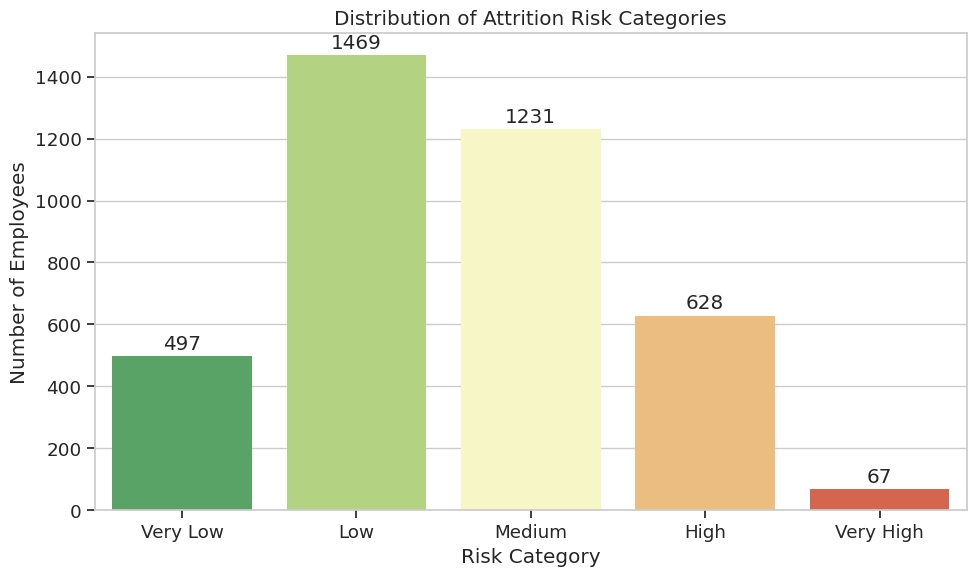


Average Attrition Risk by Department:
Department
Collections         0.434478
Risk Management     0.434138
Sales               0.431288
Customer Service    0.429841
Finance             0.412281
HR                  0.397187
Legal               0.394413
Operations          0.376699
IT                  0.368599
Executive           0.312500
Name: AttritionProbability, dtype: float64


/tmp/ipykernel_6260/4288589210.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_risk.index, y=dept_risk.values, palette='viridis')


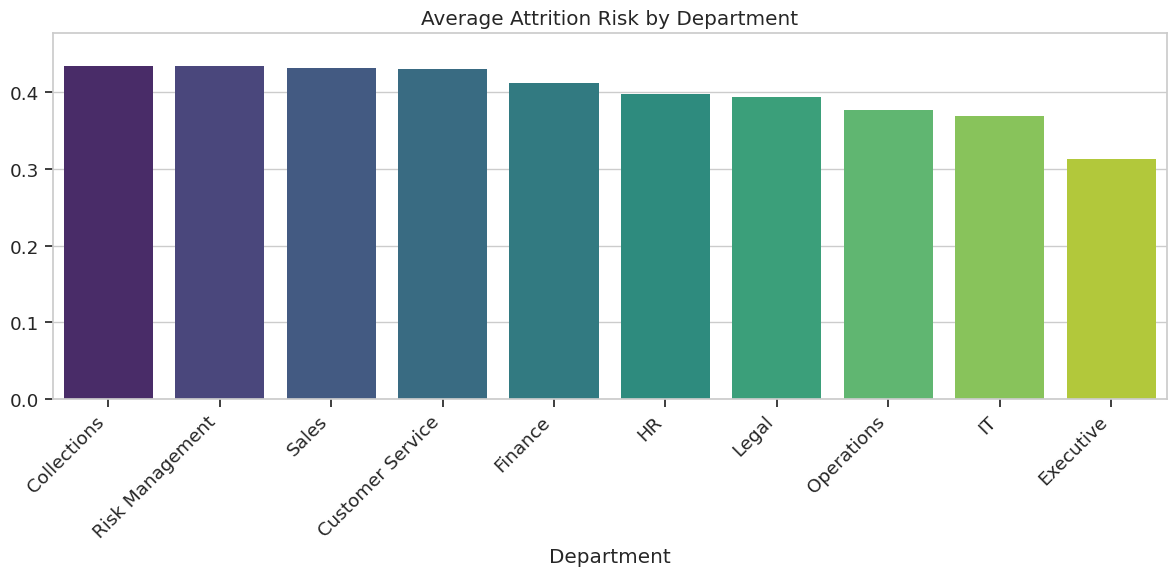

In [17]:
print(f"\nUsing {best_model_name} to create risk scoring framework...")

# Process the full dataset for prediction
print("\nPreparing the entire dataset for risk prediction...")
X_all = employees_df[numeric_features + categorical_features + binary_features].copy()
X_all_processed = preprocessor.transform(X_all)

print(f"Processed full dataset shape: {X_all_processed.shape}")

# Generate risk scores for all employees
employees_df['AttritionProbability'] = best_model.predict_proba(X_all_processed)[:,1]

# Create risk categories
employees_df['RiskCategory'] = pd.cut(
    employees_df['AttritionProbability'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# Print distribution of risk categories
risk_distribution = employees_df['RiskCategory'].value_counts().sort_index()
print("\nRisk Category Distribution:")
print(risk_distribution)

# Visualize risk distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='RiskCategory', data=employees_df, palette='RdYlGn_r')
plt.title('Distribution of Attrition Risk Categories')
plt.ylabel('Number of Employees')
plt.xlabel('Risk Category')

# Add count labels on each bar
for i, count in enumerate(risk_distribution):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analyze risk by department
dept_risk = employees_df.groupby('Department')['AttritionProbability'].mean().sort_values(ascending=False)
print("\nAverage Attrition Risk by Department:")
print(dept_risk)

plt.figure(figsize=(12, 6))
sns.barplot(x=dept_risk.index, y=dept_risk.values, palette='viridis')
plt.title('Average Attrition Risk by Department')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(dept_risk.values) * 1.1)
plt.tight_layout()
plt.show()

In [18]:
# Function to identify risk factors for each employee using SHAP values
def get_risk_factors_from_shap(employee_idx, shap_values, data, feature_names, top_n=3):
    """
    Identify top risk factors for an employee based on SHAP values
    
    Args:
        employee_idx: Index of employee in the data
        shap_values: SHAP values for all employees
        data: Feature data used to calculate SHAP values
        feature_names: Names of features
        top_n: Number of top factors to return
        
    Returns:
        List of top risk factors as strings
    """
    # Get SHAP values for this employee
    employee_shap = shap_values[employee_idx]
    
    # Create DataFrame of features and SHAP values
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_value': employee_shap
    })
    
    # Focus on features that increase attrition risk (positive SHAP values)
    shap_df = shap_df[shap_df['SHAP_value'] > 0].sort_values('SHAP_value', ascending=False)
    
    # Format risk factors in a human-readable way
    risk_factors = []
    for _, row in shap_df.head(top_n).iterrows():
        feature = row['Feature']
        
        # Format based on feature type
        if 'JobSatisfaction' in feature or 'Satisfaction' in feature:
            risk_factors.append(f"Low {feature}")
        elif 'Overtime' in feature and feature in binary_features:
            risk_factors.append("Works overtime")
        elif 'WorkLifeImbalance' in feature and feature in binary_features:
            risk_factors.append("Poor work-life balance")
        elif 'StagnationRisk' in feature and feature in binary_features:
            risk_factors.append("Career stagnation")
        elif 'Department_' in feature:
            dept = feature.replace('Department_', '')
            risk_factors.append(f"Works in {dept} department")
        elif 'JobLevel_' in feature:
            level = feature.replace('JobLevel_', '')
            risk_factors.append(f"Job level: {level}")
        else:
            risk_factors.append(feature)
    
    return risk_factors

In [19]:
# Identify high-risk employees for intervention
high_risk_employees = employees_df[
    (employees_df['RiskCategory'].isin(['High', 'Very High'])) & 
    (~employees_df['Attrition'])  # Only include current employees
].copy()

print(f"\nNumber of high-risk current employees: {len(high_risk_employees)}")


Number of high-risk current employees: 191


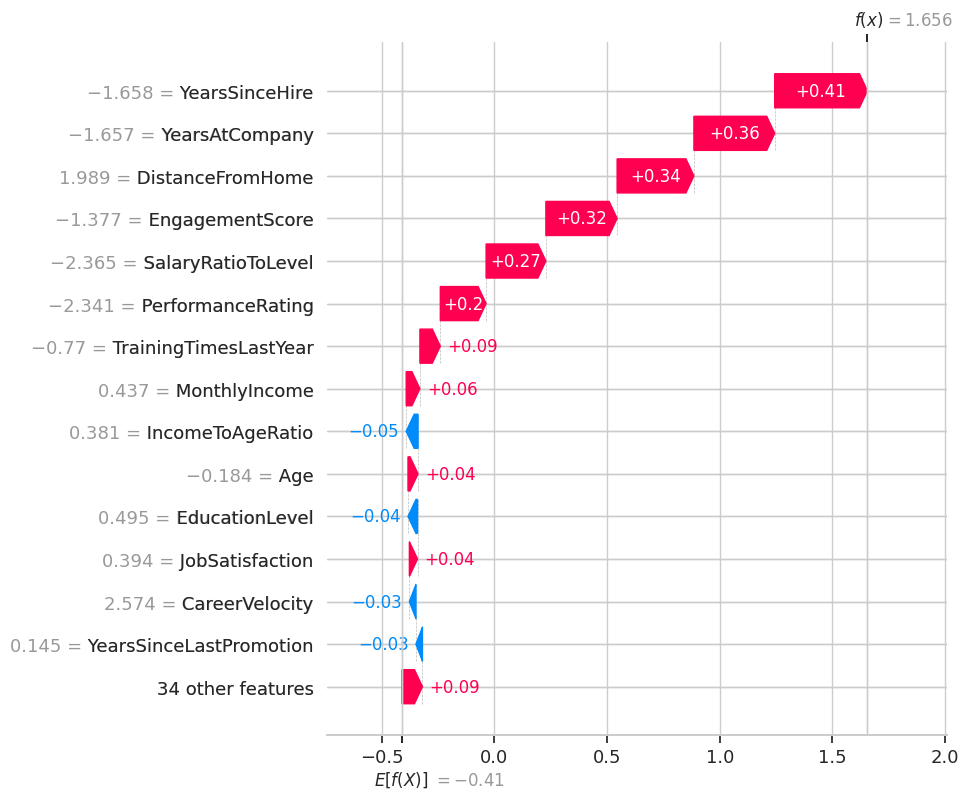


Top 5 highest-risk current employees:


,EmployeeID,Department,JobLevel,AttritionProbability,RiskCategory
2394,12395,Finance,Entry Level,0.879274,Very High
2131,12132,Sales,Director,0.831208,Very High
1486,11487,Operations,Senior,0.811289,Very High
1498,11499,Customer Service,Senior,0.808820,Very High
2619,12620,Customer Service,Senior,0.799603,High



Employee ID: 12395
Department: Finance
Job Level: Entry Level
Attrition Risk: 87.93%
Risk factors: Not available (employee not in test set)

Employee ID: 12132
Department: Sales
Job Level: Director
Attrition Risk: 83.12%
Top Risk Factors: EngagementScore, SalaryRatioDept, IncomeToAgeRatio

Employee ID: 11487
Department: Operations
Job Level: Senior
Attrition Risk: 81.13%
Top Risk Factors: DistanceFromHome, EngagementScore, Low JobSatisfaction

Employee ID: 11499
Department: Customer Service
Job Level: Senior
Attrition Risk: 80.88%
Top Risk Factors: SalaryRatioToLevel, WorkLifeBalance, SalaryRatioDept

Employee ID: 12620
Department: Customer Service
Job Level: Senior
Attrition Risk: 79.96%
Risk factors: Not available (employee not in test set)


In [22]:
# If we have SHAP values for our best model, use them to identify risk factors
if best_model_name in shap_values_dict:
    # For demonstration, get SHAP values for a subset of test employees
    test_indices = X_test_processed.index
    test_shap_values = shap_values_dict[best_model_name]['values']
    
    # Show waterfall plot for highest risk employee in test set
    if len(test_indices) > 0:
        test_probs = best_model.predict_proba(X_test_processed)[:,1]
        highest_risk_idx = np.argmax(test_probs)
        
        try:
            # plt.figure(figsize=(14, 10))
            shap.plots.waterfall(
                shap.Explanation(
                    values=test_shap_values[highest_risk_idx], 
                    base_values=shap_values_dict[best_model_name]['explainer'].expected_value 
                    if hasattr(shap_values_dict[best_model_name]['explainer'], 'expected_value') else 0,
                    data=X_test_processed.iloc[highest_risk_idx],
                    feature_names=feature_names
                ),
                max_display=15
            )
            # plt.title('SHAP Waterfall Plot - Top Risk Factors for Highest-Risk Employee')
            # plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating waterfall plot: {e}")
    
    # Create a small sample of high-risk employees for detailed analysis
    high_risk_sample = high_risk_employees.sort_values('AttritionProbability', ascending=False).head(5)
    
    print("\nTop 5 highest-risk current employees:")
    display(high_risk_sample[['EmployeeID', 'Department', 'JobLevel', 'AttritionProbability', 'RiskCategory']])
    
    for i, (idx, row) in enumerate(high_risk_sample.iterrows()):
        print(f"\nEmployee ID: {row['EmployeeID']}")
        print(f"Department: {row['Department']}")
        print(f"Job Level: {row['JobLevel']}")
        print(f"Attrition Risk: {row['AttritionProbability']:.2%}")
        
        # Get index in test set if available
        if idx in test_indices:
            test_idx = np.where(test_indices == idx)[0][0]
            risk_factors = get_risk_factors_from_shap(
                test_idx, 
                test_shap_values, 
                X_test_processed.iloc[test_idx], 
                feature_names
            )
            print(f"Top Risk Factors: {', '.join(risk_factors)}")
        else:
            print("Risk factors: Not available (employee not in test set)")

In [23]:
# Save risk scores to a CSV file for later use in the dashboard
risk_data = employees_df[['EmployeeID', 'Department', 'JobLevel', 'AttritionProbability', 'RiskCategory']]
risk_data.to_csv('../data/processed/employee_risk_scores.csv', index=False)
print("\nRisk scores saved to '../data/processed/employee_risk_scores.csv'")

# Save high-risk employees to a separate file for intervention planning
high_risk_data = high_risk_employees[['EmployeeID', 'Department', 'JobLevel', 'AttritionProbability', 'RiskCategory']]
high_risk_data.to_csv('../data/processed/high_risk_employees.csv', index=False)
print("High-risk employee details saved to '../data/processed/high_risk_employees.csv'")


Risk scores saved to '../data/processed/employee_risk_scores.csv'
High-risk employee details saved to '../data/processed/high_risk_employees.csv'
